In [1]:
!pip install hazm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install finglish

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 12.6 MB/s eta 0:00:00


In [4]:
!pip install urlextract

In [5]:
!pip install emojis

In [6]:
import pandas as pd
from hazm import *
from finglish import f2p
import re
from urlextract import URLExtract
from tqdm import tqdm
import emojis
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

Loading converters...
Loading persian word list...
Loading dictionary...


# NLP Preprocessing

In [7]:
raw_data = pd.read_csv('/content/drive/MyDrive/snappfood_review/train.csv',on_bad_lines='skip', delimiter='\t')

In [8]:
raw_data

,Unnamed: 0,comment,label,label_id
0,0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1
1,1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0
2,2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1
3,3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0
4,4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0
...,...,...,...,...
56695,56695,یک تیکه کم فرستاده بودن و با تماس من در کمترین...,HAPPY,0
56696,56696,عالی بود همه چیز ممنونم پیک هم خیلی مرتب و به ...,HAPPY,0
56697,56697,مثل همیشه عالی، من چندمین باره سفارش میدم و هر...,HAPPY,0
56698,56698,دلستر استوایی خواسته بودم اما لیمویی فرستادند,HAPPY,0


In [9]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56700 entries, 0 to 56699
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  56700 non-null  int64 
 1   comment     56700 non-null  object
 2   label       56700 non-null  object
 3   label_id    56700 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.7+ MB


In [10]:
raw_data['Unnamed: 0']

0            0
1            1
2            2
3            3
4            4
         ...  
56695    56695
56696    56696
56697    56697
56698    56698
56699    56699
Name: Unnamed: 0, Length: 56700, dtype: int64

In [11]:
raw_data['label'].unique()

array(['SAD', 'HAPPY'], dtype=object)

In [12]:
raw_data['label_id'].unique()

array([1, 0])

In [13]:
raw_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [14]:
raw_data.head()

,comment,label,label_id
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0


In [15]:
comments = raw_data['comment'].astype(str)

In [16]:
normalizer = Normalizer()

In [17]:
def is_non_persian(comment):
    # Normalize the comment
    normalized_comment = normalizer.normalize(comment)

    # Tokenize the normalized comment
    tokens = word_tokenize(normalized_comment)

    # Check if all tokens are non-Persian (contain ASCII characters)
    return all(token.isascii() for token in tokens)

# Apply the is_non_persian function to each comment
raw_data['is_non_persian'] = comments.apply(is_non_persian)

In [18]:
non_persian_comments = raw_data[raw_data['is_non_persian']]

In [19]:
non_persian_comments

,comment,label,label_id,is_non_persian
13,Kheili khub bud mersi vaghan,HAPPY,0,True
473,Shirmoz por az shekar boood engar shiro shekar...,SAD,1,True
506,vaghean ham kheyli tamiz baste bandi shode bod...,HAPPY,0,True
952,kheili khob bod tame naget bi nazir bod sib za...,HAPPY,0,True
985,Mesle hamishe ba keyfiat va taze,HAPPY,0,True
...,...,...,...,...
55478,Kheili ba harekatesh hal kardam yelitri bud to...,HAPPY,0,True
55601,Khamire pitza fogholade kham va napokhte bkd,SAD,1,True
55843,Kheili Sari Ersal shod- Peyk kheili Moadab bood,HAPPY,0,True
55855,One time again fork and knife is missing in sl...,SAD,1,True


In [20]:
finglish_comment_indices = non_persian_comments.index

In [21]:
finglish_comment_indices

Int64Index([   13,   473,   506,   952,   985,  1099,  1329,  1347,  1577,
             1818,
            ...
            54193, 54684, 54727, 55137, 55189, 55478, 55601, 55843, 55855,
            55873],
           dtype='int64', length=175)

In [22]:
# Create a subset DataFrame with only the specific comments
specific_comments_df = raw_data.loc[finglish_comment_indices]

# Apply the f2p function to the 'comment' column of the subset DataFrame
for index in finglish_comment_indices:
    raw_data.at[index, 'comment'] = f2p(raw_data.at[index, 'comment'])

In [23]:
raw_data.head()

,comment,label,label_id,is_non_persian
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1,False
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0,False
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1,False
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0,False
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0,False


In [24]:
raw_data.loc[finglish_comment_indices]

,comment,label,label_id,is_non_persian
13,خیلی خوب بود مرسی وقن,HAPPY,0,True
473,شیرمز پر از شکار بود انگار شیر شکار میخر عدم,SAD,1,True
506,واقعاً هم خیلی تمیز بسته بندی شد بود هم خیلی خ...,HAPPY,0,True
952,خیلی خوب بود تام ناگت بی نظیر بود سیب زمینی با...,HAPPY,0,True
985,مثل همیشه با کیفیت وا تازه,HAPPY,0,True
...,...,...,...,...
55478,خیلی با حرکتش حال کردم یلیتری بود تو یک انیم ر...,HAPPY,0,True
55601,خمیر پیتزا فقلدع خام وا نپخته بکد,SAD,1,True
55843,خیلی سری ارسال شد پیک خیلی مودب بود,HAPPY,0,True
55855,ان تیم اگین فرک اند کنیفع ایس میسینگ این سلد و...,SAD,1,True


In [25]:
def _multiple_replace(mapping, text):
    pattern = "|".join(map(re.escape, mapping.keys()))
    return re.sub(pattern, lambda m: mapping[m.group()], str(text))

In [26]:
def convert_fa_numbers(input_str):
    mapping = {
        '۰': '0',
        '۱': '1',
        '۲': '2',
        '۳': '3',
        '۴': '4',
        '۵': '5',
        '۶': '6',
        '۷': '7',
        '۸': '8',
        '۹': '9',
        '.': '.',
    }
    return _multiple_replace(mapping, input_str)

In [27]:
def convert_ar_characters(input_str):
    """
    Converts Arabic chars to related Persian unicode char
    :param input_str: String contains Arabic chars
    :return: New str with converted arabic chars
    """
    mapping = {
        'ك': 'ک',
        'ى': 'ی',
        'ي': 'ی',
        'ئ':'ی',
        'إ':'ا',
        'أ':'ا',
        'ة':'ه',
        'ؤ':'و'
    }
    return _multiple_replace(mapping, input_str)

In [28]:
def preprocess(text):
    extractor = URLExtract()
    for url in extractor.gen_urls(text):
        text = text.replace(url,'<URL>')
    emj = emojis.get(text)
    for i in emj:
        if i in text:
            text = text.replace(i,'<emoji>')
    text = convert_fa_numbers(text)
    text = convert_ar_characters(text)
    # regex to detect and replace all smilies in the text with <smiley>
    text = re.sub(r"(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:\s?D|8-\)|:\s?\||;\s?\)|:-\*|:-\||:-\(|:\s?P|:-P|:-p|:-b|:-O|:-o|:-0|:-\@|:\$|:-\^|:-&|:-\*|:-\+|:-\~|:-\`|:-\>|:-\<|:-\}|:-\{|\[:\s?\]|\[:\s?\]|:\s?\]|:\s?\[|:\s?\}|:\s?\{)",'<smiley>',text)
    text = text.lower() # we lowercase here to prevent changes in the URLs and smilies
    text = text.strip()
    text = re.sub(r'[<>#.:()"\'!?؟،,@$%^&*_+\[\]/]', ' ', text)
    text = re.sub(r'[\s]{2,}', ' ', text)
    text = re.sub(r'(\w)\1{2,}', r'\1',text)
    if re.search(r'[\u0600-\u06FF]', text):
        return(text)
    else:
        return 'None'

In [29]:
raw_data

,comment,label,label_id,is_non_persian
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1,False
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0,False
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1,False
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0,False
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0,False
...,...,...,...,...
56695,یک تیکه کم فرستاده بودن و با تماس من در کمترین...,HAPPY,0,False
56696,عالی بود همه چیز ممنونم پیک هم خیلی مرتب و به ...,HAPPY,0,False
56697,مثل همیشه عالی، من چندمین باره سفارش میدم و هر...,HAPPY,0,False
56698,دلستر استوایی خواسته بودم اما لیمویی فرستادند,HAPPY,0,False


In [30]:
raw_data.drop(['is_non_persian'], axis=1, inplace=True)

In [31]:
raw_data['comment'][985]

'مثل همیشه با کیفیت وا تازه'

In [32]:
tqdm.pandas()

In [33]:
clean_df = raw_data.copy(deep=True)

In [34]:
clean_df

,comment,label,label_id
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0
...,...,...,...
56695,یک تیکه کم فرستاده بودن و با تماس من در کمترین...,HAPPY,0
56696,عالی بود همه چیز ممنونم پیک هم خیلی مرتب و به ...,HAPPY,0
56697,مثل همیشه عالی، من چندمین باره سفارش میدم و هر...,HAPPY,0
56698,دلستر استوایی خواسته بودم اما لیمویی فرستادند,HAPPY,0


In [35]:
# clean_df['Cleaned'] = clean_df['comment'].progress_apply(preprocess)

In [36]:
clean_df.head()

,comment,label,label_id
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0


In [37]:
#saved the model for further use, cause it took so much time to apply the preprocessing functions
# clean_df.to_csv('/content/drive/MyDrive/snappfood_review/reviews_cleaned_v1.csv')

In [38]:
clean_df = pd.read_csv('/content/drive/MyDrive/snappfood_review/reviews_cleaned_v1.csv')

In [39]:
clean_df.head()

,Unnamed: 0,comment,label,label_id,Cleaned
0,0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح
1,1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0,قرار بود 1 ساعته برسه ولی نیم ساعت زودتر از مو...
2,2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1,قیمت این مدل اصلا با کیفیتش سازگاری نداره فقط ...
3,3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0,عالی بود همه چه درست و به اندازه و کیفیت خوب ا...
4,4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0,شیرینی وانیلی فقط یک مدل بود


In [40]:
clean_df.isna().sum()

Unnamed: 0    0
comment       0
label         0
label_id      0
Cleaned       0
dtype: int64

In [41]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56700 entries, 0 to 56699
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  56700 non-null  int64 
 1   comment     56700 non-null  object
 2   label       56700 non-null  object
 3   label_id    56700 non-null  int64 
 4   Cleaned     56700 non-null  object
dtypes: int64(2), object(3)
memory usage: 2.2+ MB


In [42]:
clean_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [43]:
clean_df.drop(finglish_comment_indices, inplace=True)

Use TF-IDF Vectorizing

In [56]:
# Example usage with specific parameters
tfidf_vectorizer = TfidfVectorizer(min_df=2, max_features=10000)
X_tfidf = tfidf_vectorizer.fit_transform(clean_df.Cleaned)

In [57]:
labels = clean_df['label_id'].values

In [58]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(clean_df['Cleaned'], clean_df['label_id'], test_size=0.2, random_state=42)

# Vectorize the data
vectorizer = TfidfVectorizer(min_df=2, max_features=10000)
X_tfidf_train = vectorizer.fit_transform(X_train).todense()
X_tfidf_test = vectorizer.transform(X_test).todense()

In [59]:
# Convert to PyTorch tensors
X_tfidf_train_tensor = torch.tensor(X_tfidf_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_tfidf_test_tensor = torch.tensor(X_tfidf_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# PyTorch DataLoader
train_loader = DataLoader(list(zip(X_tfidf_train_tensor, y_train_tensor)), batch_size=32, shuffle=True)
test_loader = DataLoader(list(zip(X_tfidf_test_tensor, y_test_tensor)), batch_size=32, shuffle=False)

#Logistic Regression

In [60]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegressionModel, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        return torch.softmax(self.fc(x), dim=1)

logistic_model = LogisticRegressionModel(X_tfidf_train.shape[1], 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(logistic_model.parameters(), lr=0.001)

In [61]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# Lists to store results for plotting
train_accs = []
train_f1s = []

lr_test_accs = []
lr_test_f1s = []

# Training
for epoch in range(10):
    logistic_model.train()
    all_preds_train = []
    all_labels_train = []
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = logistic_model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds_train = torch.argmax(outputs, dim=1)
        all_preds_train.extend(preds_train.cpu().numpy())
        all_labels_train.extend(labels.cpu().numpy())

    # Calculate metrics for training
    train_acc = accuracy_score(all_labels_train, all_preds_train)
    train_f1 = f1_score(all_labels_train, all_preds_train, average='weighted')
    train_accs.append(train_acc)
    train_f1s.append(train_f1)

    # Evaluation
    logistic_model.eval()
    with torch.no_grad():
        all_preds_test = []
        all_labels_test = []
        for inputs, labels in test_loader:
            assert len(inputs) == len(labels), "Mismatch in batch size"
            outputs = logistic_model(inputs.float())

            preds_test = torch.argmax(outputs, dim=1)
            all_preds_test.extend(preds_test.cpu().numpy())
            all_labels_test.extend(labels.cpu().numpy())

        # Calculate metrics for testing
        test_acc = accuracy_score(all_labels_test, all_preds_test)
        test_f1 = f1_score(all_labels_test, all_preds_test, average='weighted')
        lr_test_accs.append(test_acc)
        lr_test_f1s.append(test_f1)

    print(f"Epoch {epoch + 1} - "
          f"Train Accuracy: {train_acc * 100:.2f}% | Train F1 Score: {train_f1:.4f} | "
          f"Test Accuracy: {test_acc * 100:.2f}% | Test F1 Score: {test_f1:.4f}")

Epoch 1 - Train Accuracy: 81.66% | Train F1 Score: 0.8153 | Test Accuracy: 83.76% | Test F1 Score: 0.8362
Epoch 2 - Train Accuracy: 84.59% | Train F1 Score: 0.8450 | Test Accuracy: 84.56% | Test F1 Score: 0.8446
Epoch 3 - Train Accuracy: 85.52% | Train F1 Score: 0.8545 | Test Accuracy: 84.96% | Test F1 Score: 0.8488
Epoch 4 - Train Accuracy: 86.03% | Train F1 Score: 0.8598 | Test Accuracy: 85.31% | Test F1 Score: 0.8524
Epoch 5 - Train Accuracy: 86.41% | Train F1 Score: 0.8636 | Test Accuracy: 85.44% | Test F1 Score: 0.8537
Epoch 6 - Train Accuracy: 86.78% | Train F1 Score: 0.8673 | Test Accuracy: 85.72% | Test F1 Score: 0.8567
Epoch 7 - Train Accuracy: 87.03% | Train F1 Score: 0.8699 | Test Accuracy: 85.90% | Test F1 Score: 0.8585
Epoch 8 - Train Accuracy: 87.24% | Train F1 Score: 0.8721 | Test Accuracy: 85.98% | Test F1 Score: 0.8594
Epoch 9 - Train Accuracy: 87.44% | Train F1 Score: 0.8740 | Test Accuracy: 86.00% | Test F1 Score: 0.8596
Epoch 10 - Train Accuracy: 87.63% | Train F1 S

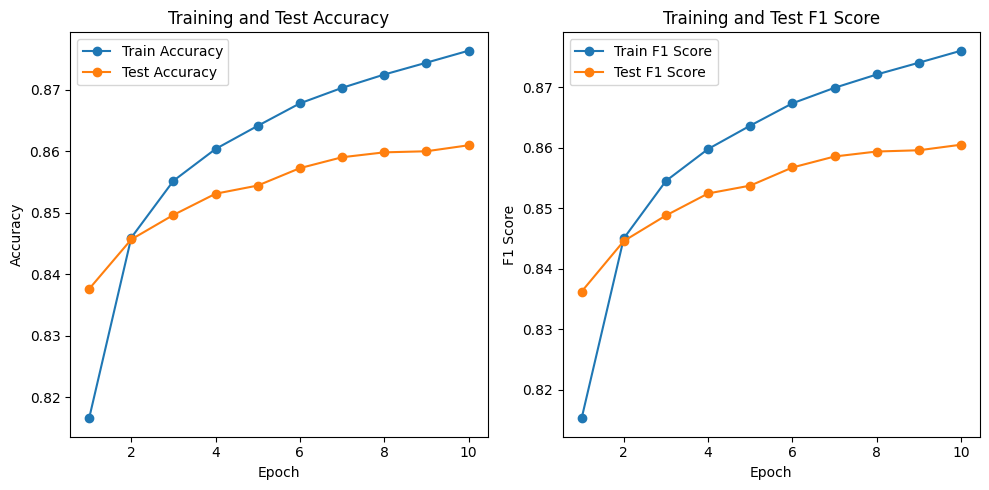

In [62]:
# Plotting
plt.figure(figsize=(10, 5))

# Plot Training and Test Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, 11), lr_test_accs, label='Test Accuracy', marker='o')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Test F1 Score
plt.subplot(1, 2, 2)
plt.plot(range(1, 11), train_f1s, label='Train F1 Score', marker='o')
plt.plot(range(1, 11), lr_test_f1s, label='Test F1 Score', marker='o')
plt.title('Training and Test F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

#LSTM

In [63]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [64]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)

        # Forward pass through the LSTM layer
        out, _ = self.lstm(x, (h0, c0))

        # Take the output from the last time step
        out = out[:, -1, :]

        # Fully connected layer
        out = self.fc(out)
        return torch.softmax(out, dim=1)

In [65]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# Initialize the LSTM model
lstm_model = LSTMModel(X_tfidf_train_tensor.shape[1], 128, 2).to(device)

# Loss and optimizer
criterion_lstm = nn.CrossEntropyLoss()
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=0.001)


# Lists to store results for plotting
lstm_train_accs = []
lstm_test_accs = []
lstm_train_f1s = []
lstm_test_f1s = []

# Training
for epoch in range(10):
    lstm_model.train()
    for inputs, labels in train_loader:
        inputs = inputs.view(-1, 1, X_tfidf_train_tensor.shape[1]).to(device)
        labels = labels.to(device)

        optimizer_lstm.zero_grad()
        outputs = lstm_model(inputs)
        loss = criterion_lstm(outputs, labels)
        loss.backward()
        optimizer_lstm.step()

    # Evaluation on training set
    with torch.no_grad():
        y_train_pred = lstm_model(X_tfidf_train_tensor.view(-1, 1, X_tfidf_train_tensor.shape[1]).to(device))
        y_train_predclass = torch.argmax(y_train_pred, dim=1)

    train_accuracy = accuracy_score(y_train_tensor.cpu().numpy(), y_train_predclass.cpu().numpy())
    train_f1 = f1_score(y_train_tensor.cpu().numpy(), y_train_predclass.cpu().numpy(), average='weighted')
    lstm_train_accs.append(train_accuracy)
    lstm_train_f1s.append(train_f1)

    # Evaluation on test set
    with torch.no_grad():
        y_test_pred = lstm_model(X_tfidf_test_tensor.view(-1, 1, X_tfidf_test_tensor.shape[1]).to(device))
        y_test_predclass = torch.argmax(y_test_pred, dim=1)

    test_accuracy = accuracy_score(y_test_tensor.cpu().numpy(), y_test_predclass.cpu().numpy())
    test_f1 = f1_score(y_test_tensor.cpu().numpy(), y_test_predclass.cpu().numpy(), average='weighted')
    lstm_test_accs.append(test_accuracy)
    lstm_test_f1s.append(test_f1)

    print(f"Epoch {epoch + 1} - "
          f"Train Accuracy: {train_accuracy:.4f}, Train F1 Score: {train_f1:.4f} | "
          f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")

Epoch 1 - Train Accuracy: 0.8832, Train F1 Score: 0.8832 | Test Accuracy: 0.8573, Test F1 Score: 0.8572
Epoch 2 - Train Accuracy: 0.9018, Train F1 Score: 0.9016 | Test Accuracy: 0.8546, Test F1 Score: 0.8543
Epoch 3 - Train Accuracy: 0.9086, Train F1 Score: 0.9084 | Test Accuracy: 0.8494, Test F1 Score: 0.8490
Epoch 4 - Train Accuracy: 0.9148, Train F1 Score: 0.9147 | Test Accuracy: 0.8464, Test F1 Score: 0.8461
Epoch 5 - Train Accuracy: 0.9176, Train F1 Score: 0.9175 | Test Accuracy: 0.8453, Test F1 Score: 0.8451
Epoch 6 - Train Accuracy: 0.9198, Train F1 Score: 0.9197 | Test Accuracy: 0.8418, Test F1 Score: 0.8417
Epoch 7 - Train Accuracy: 0.9212, Train F1 Score: 0.9211 | Test Accuracy: 0.8432, Test F1 Score: 0.8427
Epoch 8 - Train Accuracy: 0.9236, Train F1 Score: 0.9235 | Test Accuracy: 0.8408, Test F1 Score: 0.8405
Epoch 9 - Train Accuracy: 0.9245, Train F1 Score: 0.9245 | Test Accuracy: 0.8418, Test F1 Score: 0.8415
Epoch 10 - Train Accuracy: 0.9263, Train F1 Score: 0.9262 | Test

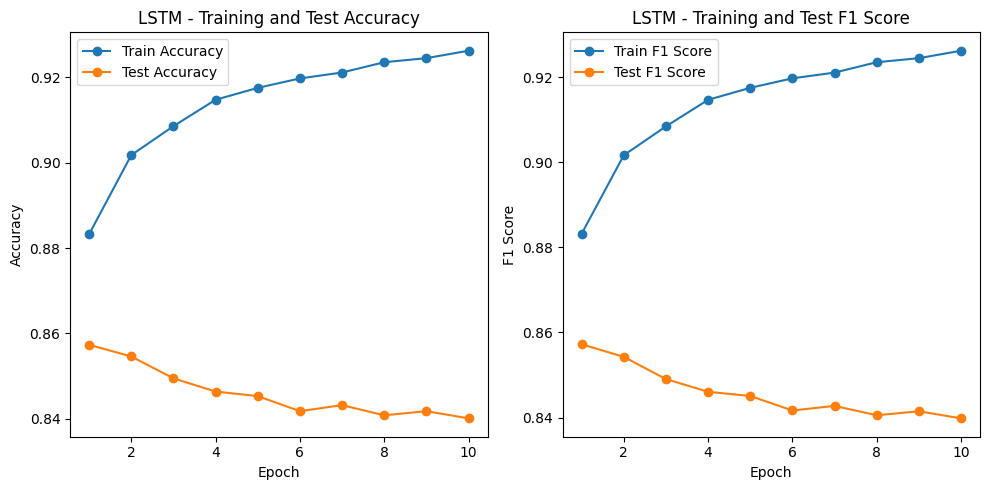

In [66]:
# Plotting LSTM results
plt.figure(figsize=(10, 5))

# Plot Training and Test Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), lstm_train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, 11), lstm_test_accs, label='Test Accuracy', marker='o')
plt.title('LSTM - Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Test F1 Score
plt.subplot(1, 2, 2)
plt.plot(range(1, 11), lstm_train_f1s, label='Train F1 Score', marker='o')
plt.plot(range(1, 11), lstm_test_f1s, label='Test F1 Score', marker='o')
plt.title('LSTM - Training and Test F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


# Simple Neural Network

In [67]:
# Move data to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tfidf_train_tensor = X_tfidf_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_tfidf_test_tensor = X_tfidf_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

class SimpleNeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 1000)
        self.activation1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)

        self.layer2 = nn.Linear(1000, 500)
        self.activation2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)

        self.layer3 = nn.Linear(500, 50)
        self.activation3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)

        self.output_layer = nn.Linear(50, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation1(x)
        x = self.dropout1(x)

        x = self.layer2(x)
        x = self.activation2(x)
        x = self.dropout2(x)

        x = self.layer3(x)
        x = self.activation3(x)
        x = self.dropout3(x)

        x = self.output_layer(x)
        x = self.softmax(x)
        return x

# Instantiate the model and move to GPU
model = SimpleNeuralNetwork(X_tfidf_train_tensor.shape[1], 2).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [68]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# Define your model, criterion, optimizer, train_loader, and test_loader here

# Lists to store results for plotting
nn_train_accs = []
nn_test_accs = []
nn_train_f1s = []
nn_test_f1s = []

# Training loop
for epoch in range(10):
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    # Evaluation on training set
    with torch.no_grad():
        y_train_pred = model(X_tfidf_train_tensor)
        y_train_predclass = torch.argmax(y_train_pred, dim=1)

    train_accuracy = accuracy_score(y_train_tensor.cpu().numpy(), y_train_predclass.cpu().numpy())
    train_f1 = f1_score(y_train_tensor.cpu().numpy(), y_train_predclass.cpu().numpy(), average='weighted')
    nn_train_accs.append(train_accuracy)
    nn_train_f1s.append(train_f1)

    # Evaluation on test set
    with torch.no_grad():
        y_test_pred = model(X_tfidf_test_tensor)
        y_test_predclass = torch.argmax(y_test_pred, dim=1)

    test_accuracy = accuracy_score(y_test_tensor.cpu().numpy(), y_test_predclass.cpu().numpy())
    test_f1 = f1_score(y_test_tensor.cpu().numpy(), y_test_predclass.cpu().numpy(), average='weighted')
    nn_test_accs.append(test_accuracy)
    nn_test_f1s.append(test_f1)

    print(f"Epoch {epoch + 1} - "
          f"Train Accuracy: {train_accuracy:.4f}, Train F1 Score: {train_f1:.4f} | "
          f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")

Epoch 1 - Train Accuracy: 0.8799, Train F1 Score: 0.8794 | Test Accuracy: 0.8495, Test F1 Score: 0.8487
Epoch 2 - Train Accuracy: 0.8987, Train F1 Score: 0.8986 | Test Accuracy: 0.8482, Test F1 Score: 0.8479
Epoch 3 - Train Accuracy: 0.9113, Train F1 Score: 0.9112 | Test Accuracy: 0.8457, Test F1 Score: 0.8455
Epoch 4 - Train Accuracy: 0.9224, Train F1 Score: 0.9223 | Test Accuracy: 0.8466, Test F1 Score: 0.8462
Epoch 5 - Train Accuracy: 0.9282, Train F1 Score: 0.9281 | Test Accuracy: 0.8433, Test F1 Score: 0.8431
Epoch 6 - Train Accuracy: 0.9327, Train F1 Score: 0.9326 | Test Accuracy: 0.8452, Test F1 Score: 0.8450
Epoch 7 - Train Accuracy: 0.9366, Train F1 Score: 0.9366 | Test Accuracy: 0.8427, Test F1 Score: 0.8426
Epoch 8 - Train Accuracy: 0.9399, Train F1 Score: 0.9399 | Test Accuracy: 0.8397, Test F1 Score: 0.8397
Epoch 9 - Train Accuracy: 0.9409, Train F1 Score: 0.9409 | Test Accuracy: 0.8374, Test F1 Score: 0.8374
Epoch 10 - Train Accuracy: 0.9424, Train F1 Score: 0.9424 | Test

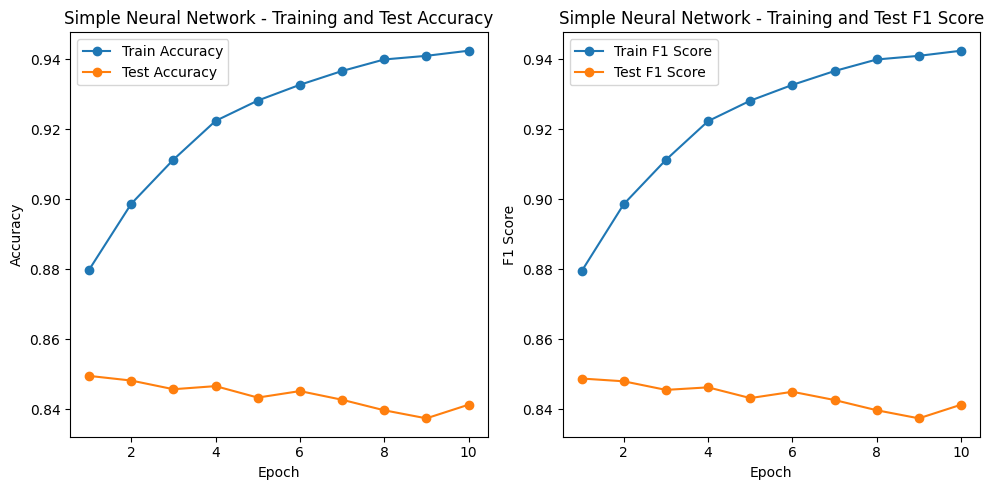

In [69]:
# Plotting Simple Neural Network results
plt.figure(figsize=(10, 5))

# Plot Training and Test Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), nn_train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, 11), nn_test_accs, label='Test Accuracy', marker='o')
plt.title('Simple Neural Network - Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Test F1 Score
plt.subplot(1, 2, 2)
plt.plot(range(1, 11), nn_train_f1s, label='Train F1 Score', marker='o')
plt.plot(range(1, 11), nn_test_f1s, label='Test F1 Score', marker='o')
plt.title('Simple Neural Network - Training and Test F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

#Bidirectional LSTM

In [48]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

X = clean_df['Cleaned']
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=100)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.long)

# Assuming 'labels' is a separate variable in your dataset
labels = torch.tensor(clean_df['label_id'].values, dtype=torch.long)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, labels, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train_cat = nn.functional.one_hot(y_train, num_classes=2).float()
y_test_cat = nn.functional.one_hot(y_test, num_classes=2).float()

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train_cat)
test_dataset = TensorDataset(X_test, y_test_cat)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [49]:
# Initialize the BiLSTM model
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, num_classes):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(hidden_size * 2, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        packed_sequence = pack_padded_sequence(x, torch.tensor([100]*len(x)), batch_first=True, enforce_sorted=False)
        lstm_out, _ = self.lstm(packed_sequence)
        lstm_out, _ = pad_packed_sequence(lstm_out, batch_first=True)
        out = torch.mean(lstm_out, dim=1)  # You can choose a different pooling strategy here
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

In [52]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# Initialize the BiLSTM model
bi_lstm_model = BiLSTMModel(input_size=20000, embedding_dim=32, hidden_size=128, num_classes=2).to(device)

# Loss and optimizer
criterion_bi_lstm = nn.CrossEntropyLoss()
optimizer_bi_lstm = optim.Adam(bi_lstm_model.parameters(), lr=1e-4)

# Lists to store results for plotting
bi_lstm_train_accs = []
bi_lstm_test_accs = []
bi_lstm_train_f1s = []
bi_lstm_test_f1s = []

# Training
for epoch in range(10):
    bi_lstm_model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer_bi_lstm.zero_grad()
        outputs = bi_lstm_model(inputs)
        loss = criterion_bi_lstm(outputs, torch.argmax(labels, dim=1))
        loss.backward()
        optimizer_bi_lstm.step()

    # Evaluation
    bi_lstm_model.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = bi_lstm_model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())

        # Calculate metrics
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        bi_lstm_test_accs.append(acc)
        bi_lstm_test_f1s.append(f1)

    print(f"Epoch {epoch + 1} - Test Accuracy: {acc * 100:.2f}% | F1 Score: {f1:.4f}")

Epoch 1 - Test Accuracy: 66.49% | F1 Score: 0.6583
Epoch 2 - Test Accuracy: 72.54% | F1 Score: 0.7151
Epoch 3 - Test Accuracy: 75.52% | F1 Score: 0.7498
Epoch 4 - Test Accuracy: 77.43% | F1 Score: 0.7740
Epoch 5 - Test Accuracy: 78.19% | F1 Score: 0.7818
Epoch 6 - Test Accuracy: 80.11% | F1 Score: 0.7994
Epoch 7 - Test Accuracy: 80.76% | F1 Score: 0.8057
Epoch 8 - Test Accuracy: 80.87% | F1 Score: 0.8085
Epoch 9 - Test Accuracy: 81.32% | F1 Score: 0.8131
Epoch 10 - Test Accuracy: 82.06% | F1 Score: 0.8200


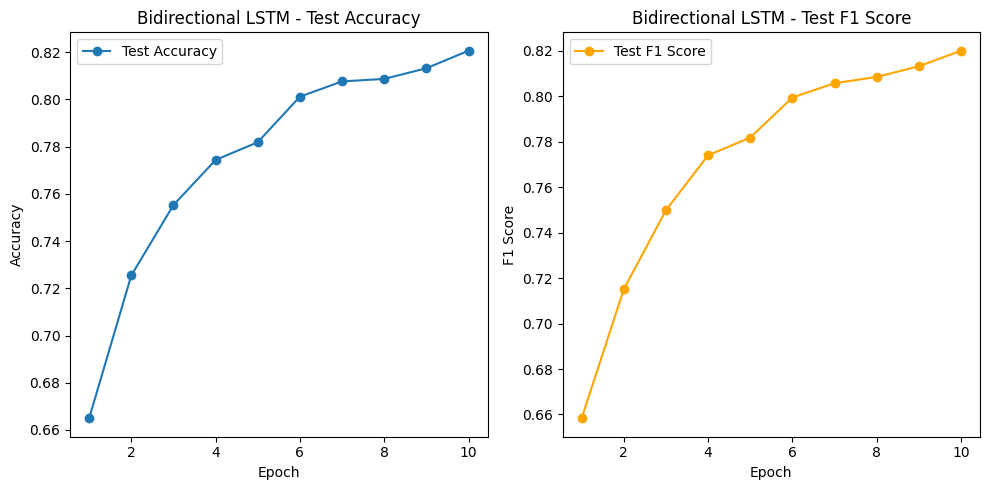

In [53]:
# Plotting Bidirectional LSTM results
plt.figure(figsize=(10, 5))

# Plot Test Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), bi_lstm_test_accs, label='Test Accuracy', marker='o')
plt.title('Bidirectional LSTM - Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Test F1 Score
plt.subplot(1, 2, 2)
plt.plot(range(1, 11), bi_lstm_test_f1s, label='Test F1 Score', marker='o', color='orange')
plt.title('Bidirectional LSTM - Test F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

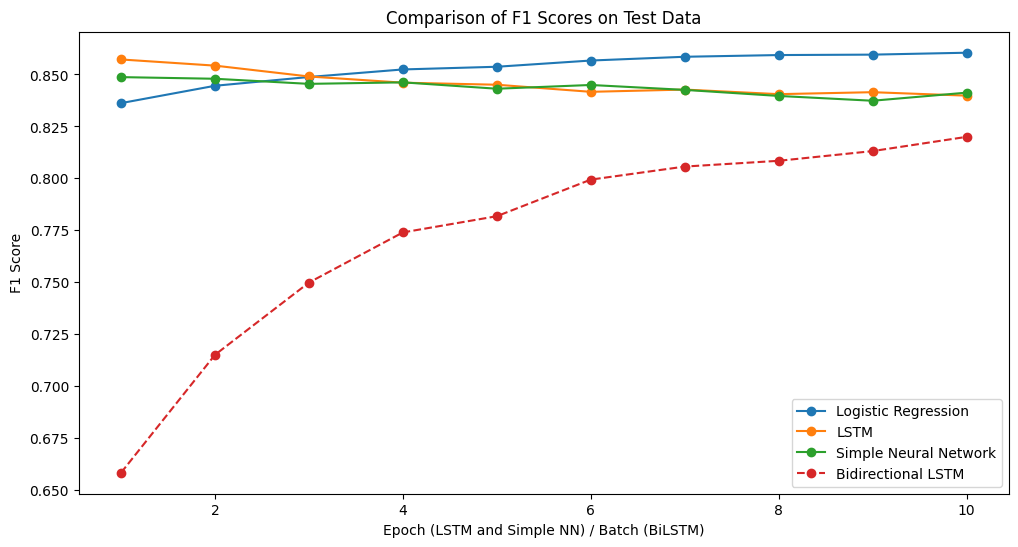

In [70]:
plt.figure(figsize=(12, 6))

# Plot F1 Scores for all models
plt.plot(range(1, 11), lr_test_f1s, label='Logistic Regression', marker='o')
plt.plot(range(1, 11), lstm_test_f1s, label='LSTM', marker='o')
plt.plot(range(1, 11), nn_test_f1s, label='Simple Neural Network', marker='o')
plt.plot(range(1, 11), bi_lstm_test_f1s, label='Bidirectional LSTM', marker='o', linestyle='dashed')

plt.title('Comparison of F1 Scores on Test Data')
plt.xlabel('Epoch (LSTM and Simple NN) / Batch (BiLSTM)')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

#other preprocessings

In [71]:
preprocessed_data = pd.DataFrame(clean_df[['Cleaned', 'label_id']])

In [72]:
preprocessed_data

,Cleaned,label_id
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,1
1,قرار بود 1 ساعته برسه ولی نیم ساعت زودتر از مو...,0
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره فقط ...,1
3,عالی بود همه چه درست و به اندازه و کیفیت خوب ا...,0
4,شیرینی وانیلی فقط یک مدل بود,0
...,...,...
56695,یک تیکه کم فرستاده بودن و با تماس من در کمترین...,0
56696,عالی بود همه چیز ممنونم پیک هم خیلی مرتب و به ...,0
56697,مثل همیشه عالی من چندمین باره سفارش میدم و هرب...,0
56698,دلستر استوایی خواسته بودم اما لیمویی فرستادند,0


In [73]:
# Apply the preprocessing steps to the 'comment' column, normalizer, tokenizer, stemmer, lemmatizer and removing the stop words

hazm_normalizer = Normalizer()
preprocessed_data['comment'] = preprocessed_data['Cleaned'].apply(lambda v: hazm_normalizer.normalize(v))

hazm_tokenizer = WordTokenizer(replace_numbers=True, replace_ids=True)
preprocessed_data['comment'] = preprocessed_data['comment'].apply(lambda v: hazm_tokenizer.tokenize(v))

hazm_stemmer = Stemmer()
preprocessed_data['comment'] = preprocessed_data['comment'].apply(lambda v: [hazm_stemmer.stem(w) for w in v])

hazm_lemmatizer = Lemmatizer()
preprocessed_data['comment'] = preprocessed_data['comment'].apply(lambda v: [hazm_lemmatizer.lemmatize(w) for w in v])

stopwords = stopwords_list()
preprocessed_data['comment'] = preprocessed_data['comment'].apply(lambda v: [w for w in v if w not in stopwords])

preprocessed_data['comment'] = preprocessed_data['comment'].apply(lambda v: ' '.join(v))


In [74]:
preprocessed_data

,Cleaned,label_id,comment
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,1,واقعا حیف وق بنویس سرویس دهیتون افتضاح
1,قرار بود 1 ساعته برسه ولی نیم ساعت زودتر از مو...,0,قرار بود#است NUM 1 ساعته برسه ول #هست ساع زود ...
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره فقط ...,1,قیم مدل اصلا کیفیت سازگار نداره ظاهر فریبنده د...
3,عالی بود همه چه درست و به اندازه و کیفیت خوب ا...,0,عال بود#است درس اندازه کیف امیداور کیفیتتون با...
4,شیرینی وانیلی فقط یک مدل بود,0,شیرین وانیل مدل بود#است
...,...,...,...
56695,یک تیکه کم فرستاده بودن و با تماس من در کمترین...,0,تیکه ک فرستاده تماس ک ز برا ارسال شد#شو واقعا ...
56696,عالی بود همه چیز ممنونم پیک هم خیلی مرتب و به ...,0,عال بود#است ممنون پیک #هست خیل مرتب موقع آورد#آور
56697,مثل همیشه عالی من چندمین باره سفارش میدم و هرب...,0,عال چندمین سفار مید هربار دفعه راضی سیب‌زمین د...
56698,دلستر استوایی خواسته بودم اما لیمویی فرستادند,0,دلس استوا خواست#خواه لیمو فرستاد#فرست


## Try new Embeddings- Word2Vec

In [75]:
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import numpy as np

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    preprocessed_data['comment'],
    preprocessed_data['label_id'],
    test_size=0.2,
    random_state=42
)

# Train Word2Vec model on the training set
word2vec_model = Word2Vec(X_train.apply(lambda x: x.split()), min_count=1, workers=4)

# Function to transform comments into word embeddings
def transform(X, model):
    embedded = []
    for row in X:
        single_data_item_embedding = np.zeros(100)
        word_count = 0
        for word in row.split():
            if word in model.wv:
                single_data_item_embedding += model.wv[word]
                word_count += 1
        if word_count == 0:
            embedded.append([0.0] * 100)
        else:
            single_data_item_embedding /= word_count
            embedded.append(single_data_item_embedding)
    return embedded

# Apply the transformation to the training and testing sets
wvectorized_X_train = transform(X_train, word2vec_model)
wvectorized_X_test = transform(X_test, word2vec_model)

In [76]:
# Convert to PyTorch tensors
X_wv_train_tensor = torch.tensor(wvectorized_X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_wv_test_tensor = torch.tensor(wvectorized_X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# PyTorch DataLoader
train_loader = DataLoader(list(zip(X_wv_train_tensor, y_train_tensor)), batch_size=32, shuffle=True)
test_loader = DataLoader(list(zip(X_wv_test_tensor, y_test_tensor)), batch_size=32, shuffle=False)

<ipython-input-76-22cd01bdbaf6>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  X_wv_train_tensor = torch.tensor(wvectorized_X_train, dtype=torch.float32)


In [77]:
# Initialize the LSTM model
lstm_model = LSTMModel(X_wv_train_tensor.shape[1], 128, 2).to(device)

# Loss and optimizer
criterion_lstm = nn.CrossEntropyLoss()
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=0.001)

# Training
for epoch in range(10):
    lstm_model.train()
    for inputs, labels in train_loader:
        inputs = inputs.view(-1, 1, X_wv_train_tensor.shape[1]).to(device)
        labels = labels.to(device)

        optimizer_lstm.zero_grad()
        outputs = lstm_model(inputs)
        loss = criterion_lstm(outputs, labels)
        loss.backward()
        optimizer_lstm.step()

    # Evaluation
    lstm_model.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for inputs, labels in test_loader:
            inputs = inputs.view(-1, 1, X_wv_test_tensor.shape[1]).to(device)
            labels = labels.to(device)

            outputs = lstm_model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Epoch {epoch + 1} - Test Accuracy: {acc * 100:.2f}% | F1 Score: {f1:.4f}")


Epoch 1 - Test Accuracy: 81.48% | F1 Score: 0.8135
Epoch 2 - Test Accuracy: 81.58% | F1 Score: 0.8148
Epoch 3 - Test Accuracy: 82.22% | F1 Score: 0.8217
Epoch 4 - Test Accuracy: 82.03% | F1 Score: 0.8192
Epoch 5 - Test Accuracy: 82.30% | F1 Score: 0.8222
Epoch 6 - Test Accuracy: 82.34% | F1 Score: 0.8222
Epoch 7 - Test Accuracy: 82.51% | F1 Score: 0.8244
Epoch 8 - Test Accuracy: 82.25% | F1 Score: 0.8209
Epoch 9 - Test Accuracy: 82.49% | F1 Score: 0.8235
Epoch 10 - Test Accuracy: 83.03% | F1 Score: 0.8298


## FastText

In [78]:
from gensim.models import FastText
import numpy as np

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    preprocessed_data['Cleaned'],
    preprocessed_data['label_id'],
    test_size=0.2,
    random_state=42
)

# Train FastText model on the training set
fasttext_model = FastText(sentences=X_train.apply(lambda x: x.split()), min_count=1, workers=4)

# Function to transform comments into FastText embeddings
def transform(X, model):
    embedded = []
    for row in X:
        single_data_item_embedding = np.zeros(100)
        word_count = 0
        for word in row.split():
            if word in model.wv:
                single_data_item_embedding += model.wv[word]
                word_count += 1
        if word_count == 0:
            embedded.append([0.0] * 100)
        else:
            single_data_item_embedding /= word_count
            embedded.append(single_data_item_embedding)
    return embedded

# Apply the transformation to the training and testing sets
fvectorized_X_train = transform(X_train, fasttext_model)
fvectorized_X_test = transform(X_test, fasttext_model)

# Display the first example from the training set
print(fvectorized_X_train[0])


[ 0.03953717 -0.47508961  0.06554364  1.03707716 -0.13916599  0.56087202
  0.50137055  0.32993152  0.24733373 -0.5500823   0.07782564 -0.65020112
 -0.6927289  -0.47256559  0.29568735 -0.6218468   0.15451652 -0.23524233
 -0.32160671 -0.37921237  0.45071405  0.32583591  0.37933142  0.39355256
 -1.02887863  0.66713225  0.21459948 -0.67572876 -0.07106769 -0.17812333
 -0.52677639  0.34610811  0.23428556 -0.39597427  0.23900298  0.92579468
  0.25924481 -0.47177854  0.93837695 -0.72786565 -0.42989989 -0.30077659
  0.03374153 -1.02338193  0.43233312  0.1013582   0.78022947 -0.57061402
 -0.17764866  0.26347459 -0.32997169  0.39062777  0.42125677 -0.06663274
  0.01784105 -0.36722916 -0.47060741  0.53013073 -0.44942001 -0.50911318
 -1.08652242 -1.1157611   0.14923612  0.40526936 -0.2933781  -0.60814571
 -0.49983281 -0.58247115 -0.21956269 -0.32980089 -0.39864822  0.43277614
  0.97646041 -0.09577798  1.38048371 -0.28354571 -0.35818097 -0.15259422
  0.1127545  -0.39186712 -0.01847434  0.41839284 -0

In [79]:
# Convert to PyTorch tensors
X_fv_train_tensor = torch.tensor(fvectorized_X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_fv_test_tensor = torch.tensor(fvectorized_X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# PyTorch DataLoader
train_loader = DataLoader(list(zip(X_fv_train_tensor, y_train_tensor)), batch_size=32, shuffle=True)
test_loader = DataLoader(list(zip(X_fv_test_tensor, y_test_tensor)), batch_size=32, shuffle=False)

In [80]:
# Training
for epoch in range(10):
    lstm_model.train()
    for inputs, labels in train_loader:
        inputs = inputs.view(-1, 1, X_fv_train_tensor.shape[1]).to(device)
        labels = labels.to(device)

        optimizer_lstm.zero_grad()
        outputs = lstm_model(inputs)
        loss = criterion_lstm(outputs, labels)
        loss.backward()
        optimizer_lstm.step()

    # Evaluation
    lstm_model.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for inputs, labels in test_loader:
            inputs = inputs.view(-1, 1, X_fv_test_tensor.shape[1]).to(device)
            labels = labels.to(device)

            outputs = lstm_model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Epoch {epoch + 1} - Test Accuracy: {acc * 100:.2f}% | F1 Score: {f1:.4f}")


Epoch 1 - Test Accuracy: 83.44% | F1 Score: 0.8335
Epoch 2 - Test Accuracy: 83.67% | F1 Score: 0.8359
Epoch 3 - Test Accuracy: 83.73% | F1 Score: 0.8365
Epoch 4 - Test Accuracy: 83.97% | F1 Score: 0.8388
Epoch 5 - Test Accuracy: 83.87% | F1 Score: 0.8374
Epoch 6 - Test Accuracy: 83.95% | F1 Score: 0.8386
Epoch 7 - Test Accuracy: 83.99% | F1 Score: 0.8388
Epoch 8 - Test Accuracy: 84.26% | F1 Score: 0.8420
Epoch 9 - Test Accuracy: 84.24% | F1 Score: 0.8414
Epoch 10 - Test Accuracy: 84.34% | F1 Score: 0.8427
